## Question 3: Should You Invest Now or Wait? Where Should You Invest?

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load datasets
zhvi_data = pd.read_csv('ZHVI_Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv')
zori_data = pd.read_csv('ZORI_Metro_zordi_uc_sfr_month.csv')
market_temp_data = pd.read_csv('MARKET_TEMP_Metro_market_temp_index_uc_sfrcondo_month.csv')
dttp_data = pd.read_csv('DTTP_Metro_mean_doz_pending_uc_sfrcondo_month.csv')
inventory_data = pd.read_csv('FOR_SALE_INVENTORY_Metro_invt_fs_uc_sfr_sm_month.csv')

# Display data to ensure it loaded
zhvi_data.head(), zori_data.head(), market_temp_data.head(), dttp_data.head(), inventory_data.head()
# Reshape datasets for 2023-2024
def reshape_and_filter(df, id_vars, value_name, start_year=2023, end_year=2024):
    df_long = df.melt(id_vars=id_vars, var_name="Date", value_name=value_name)
    df_long["Date"] = pd.to_datetime(df_long["Date"], errors="coerce")
    return df_long[
        (df_long["Date"].dt.year >= start_year) & (df_long["Date"].dt.year <= end_year)
    ]

In [6]:
# Extract the latest data for analysis, rename for zhvi and zori to clarify and tracking
zhvi_latest = zhvi_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'ZHVI_Latest'})
zori_latest = zori_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'ZORI_Latest'})
market_temp_latest = market_temp_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'MarketTemp_Latest'})

# Merge datasets, merging the zhvi and zori for region and state, makes it more clear and remove united states as a region
combined_data = pd.merge(zhvi_latest, zori_latest, on=['RegionName', 'StateName'], how='inner')
combined_data = pd.merge(combined_data, market_temp_latest, on=['RegionName', 'StateName'], how='inner')

# Rank markets by metrics, metrics being "hottest" by state/region 
combined_data['ZHVI_Rank'] = combined_data['ZHVI_Latest'].rank(ascending=False)
combined_data['ZORI_Rank'] = combined_data['ZORI_Latest'].rank(ascending=False)
combined_data['MarketTemp_Rank'] = combined_data['MarketTemp_Latest'].rank(ascending=False)

# Calculate overall rank
combined_data['Overall_Rank'] = combined_data[['ZHVI_Rank', 'ZORI_Rank', 'MarketTemp_Rank']].mean(axis=1)

# Top-performing markets
top_markets = combined_data.sort_values(by='Overall_Rank').head(10)
top_markets

,RegionName,StateName,ZHVI_Latest,ZORI_Latest,MarketTemp_Latest,ZHVI_Rank,ZORI_Rank,MarketTemp_Rank,Overall_Rank
35,"San Jose, CA",CA,1.702743e+06,101.0,77.0,1.0,68.5,7.0,25.500000
12,"San Francisco, CA",CA,1.227564e+06,83.0,60.0,6.0,105.0,60.5,57.166667
122,"Salinas, CA",CA,8.409708e+05,141.0,53.0,21.0,24.0,135.0,60.000000
128,"Manchester, NH",NH,5.162688e+05,89.0,68.0,69.0,91.0,21.5,60.500000
6,"Washington, DC",VA,5.962993e+05,78.0,66.0,44.0,117.5,28.0,63.166667
100,"Modesto, CA",CA,4.663186e+05,93.0,61.0,88.0,83.0,53.5,74.833333
26,"Sacramento, CA",CA,5.838314e+05,76.0,62.0,48.0,130.0,48.0,75.333333
57,"Worcester, MA",MA,4.647810e+05,85.0,65.0,89.0,101.0,36.0,75.333333
48,"Hartford, CT",CT,3.820292e+05,101.0,80.0,165.0,68.5,4.0,79.166667
83,"Springfield, MA",MA,3.568748e+05,124.0,68.0,194.0,36.5,21.5,84.000000


In [7]:
# Filter inventory_data and dttp_data for October 2023 to October 2024
def filter_by_date_range(df, start_date, end_date, id_vars, value_name):
    # Melt the dataset to reshape it
    df_long = df.melt(id_vars=id_vars, var_name="Date", value_name=value_name)
    # Convert the Date column to datetime explicitly specifying the format
    df_long["Date"] = pd.to_datetime(df_long["Date"], format="%Y-%m-%d", errors="coerce")
    # Filter by the date range
    return df_long[(df_long["Date"] >= start_date) & (df_long["Date"] <= end_date)]

# Define the date range
start_date = "2023-10-01"
end_date = "2024-10-31"

# Reshape and filter inventory_data
inventory_filtered = filter_by_date_range(
    inventory_data, start_date, end_date, id_vars=["RegionName", "StateName"], value_name="Inventory"
)

# Reshape and filter dttp_data
dttp_filtered = filter_by_date_range(
    dttp_data, start_date, end_date, id_vars=["RegionName", "StateName"], value_name="DaysOnMarket"
)

# Aggregate the filtered data to get the latest values (October 2024)
inventory_latest = inventory_filtered.groupby(["RegionName", "StateName"])["Inventory"].last().reset_index()
dttp_latest = dttp_filtered.groupby(["RegionName", "StateName"])["DaysOnMarket"].last().reset_index()

# Merge the filtered and aggregated data with top markets
investment_data = pd.merge(top_markets, inventory_latest, on=["RegionName", "StateName"], how="inner")
investment_data = pd.merge(investment_data, dttp_latest, on=["RegionName", "StateName"], how="inner")

print(investment_data)

          RegionName StateName   ZHVI_Latest  ZORI_Latest  MarketTemp_Latest  \
0       San Jose, CA        CA  1.702743e+06        101.0               77.0   
1  San Francisco, CA        CA  1.227564e+06         83.0               60.0   
2        Salinas, CA        CA  8.409708e+05        141.0               53.0   
3     Manchester, NH        NH  5.162688e+05         89.0               68.0   
4     Washington, DC        VA  5.962993e+05         78.0               66.0   
5        Modesto, CA        CA  4.663186e+05         93.0               61.0   
6     Sacramento, CA        CA  5.838314e+05         76.0               62.0   
7      Worcester, MA        MA  4.647810e+05         85.0               65.0   
8       Hartford, CT        CT  3.820292e+05        101.0               80.0   
9    Springfield, MA        MA  3.568748e+05        124.0               68.0   

   ZHVI_Rank  ZORI_Rank  MarketTemp_Rank  Overall_Rank Inventory DaysOnMarket  
0        1.0       68.5              7.

In [8]:
# Analyze inventory and days on market trends
inventory_latest = inventory_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'Inventory_Latest'})
dttp_latest = dttp_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'DaysOnMarket_Latest'})

# Merge with top markets data
investment_data = pd.merge(top_markets, inventory_latest, on=['RegionName', 'StateName'], how='inner')
investment_data = pd.merge(investment_data, dttp_latest, on=['RegionName', 'StateName'], how='inner')

# Display investment data
investment_data

,RegionName,StateName,ZHVI_Latest,ZORI_Latest,MarketTemp_Latest,ZHVI_Rank,ZORI_Rank,MarketTemp_Rank,Overall_Rank,Inventory_Latest,DaysOnMarket_Latest
0,"San Jose, CA",CA,1.702743e+06,101.0,77.0,1.0,68.5,7.0,25.500000,1933.0,28.0
1,"San Francisco, CA",CA,1.227564e+06,83.0,60.0,6.0,105.0,60.5,57.166667,6139.0,36.0
2,"Salinas, CA",CA,8.409708e+05,141.0,53.0,21.0,24.0,135.0,60.000000,599.0,43.0
3,"Manchester, NH",NH,5.162688e+05,89.0,68.0,69.0,91.0,21.5,60.500000,530.0,19.0
4,"Washington, DC",VA,5.962993e+05,78.0,66.0,44.0,117.5,28.0,63.166667,10456.0,29.0
5,"Modesto, CA",CA,4.663186e+05,93.0,61.0,88.0,83.0,53.5,74.833333,946.0,35.0
6,"Sacramento, CA",CA,5.838314e+05,76.0,62.0,48.0,130.0,48.0,75.333333,5598.0,38.0
7,"Worcester, MA",MA,4.647810e+05,85.0,65.0,89.0,101.0,36.0,75.333333,1672.0,26.0
8,"Hartford, CT",CT,3.820292e+05,101.0,80.0,165.0,68.5,4.0,79.166667,1833.0,20.0
9,"Springfield, MA",MA,3.568748e+05,124.0,68.0,194.0,36.5,21.5,84.000000,1132.0,25.0


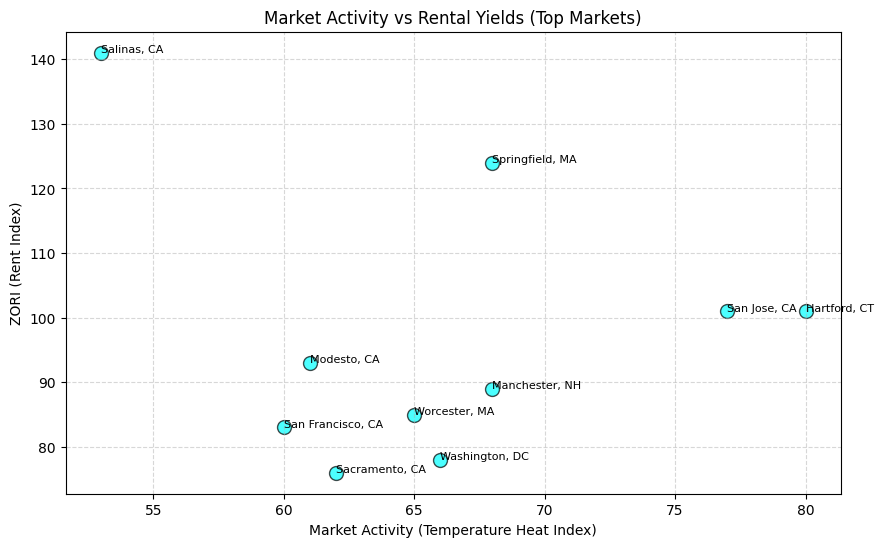

In [9]:
# Scatter plot: Market Activity vs Rental Yields
plt.figure(figsize=(10, 6))
plt.scatter(investment_data['MarketTemp_Latest'], investment_data['ZORI_Latest'], color='cyan', s=100, edgecolors='k', alpha=0.7)
for i, region in enumerate(investment_data['RegionName']):
    plt.text(investment_data['MarketTemp_Latest'].iloc[i], investment_data['ZORI_Latest'].iloc[i], region, fontsize=8)

plt.xlabel('Market Activity (Temperature Heat Index)')
plt.ylabel('ZORI (Rent Index)')
plt.title('Market Activity vs Rental Yields (Top Markets)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### **Market Activity vs Rental Yields**

This scatter plot illustrates the relationship between **Market Activity (Temperature Heat Index)** and **Rental Yields (ZORI)** in the top-performing real estate markets. It helps identify the type of opportunities each market offers based on competition and rental income potential.

- **High Rental Yields, Moderate Competition**:  
  Markets with strong rental yields but lower competition (low temperature index) could be undervalued gems. These areas may provide great opportunities for rental investments with less competition from other buyers. For example, if a market has high ZORI but relatively low Market Activity, it’s likely a lucrative market for rental income.

- **Highly Competitive Markets**:  
  In markets with high activity (high temperature index), such as **San Jose, CA**, rental yields might be lower, but these areas excel in price appreciation. Such markets are ideal for investors interested in flipping or selling upgraded properties quickly at a profit.

- **Key Takeaway**:  
  This plot helps investors balance their strategies:  
  - For rental income, focus on markets with high ZORI and moderate competition.  
  - For flipping and quick resale, target markets with high competition and appreciation potential.  
  Use this visualization to identify which markets align with your investment goals.


<Figure size 1000x800 with 0 Axes>

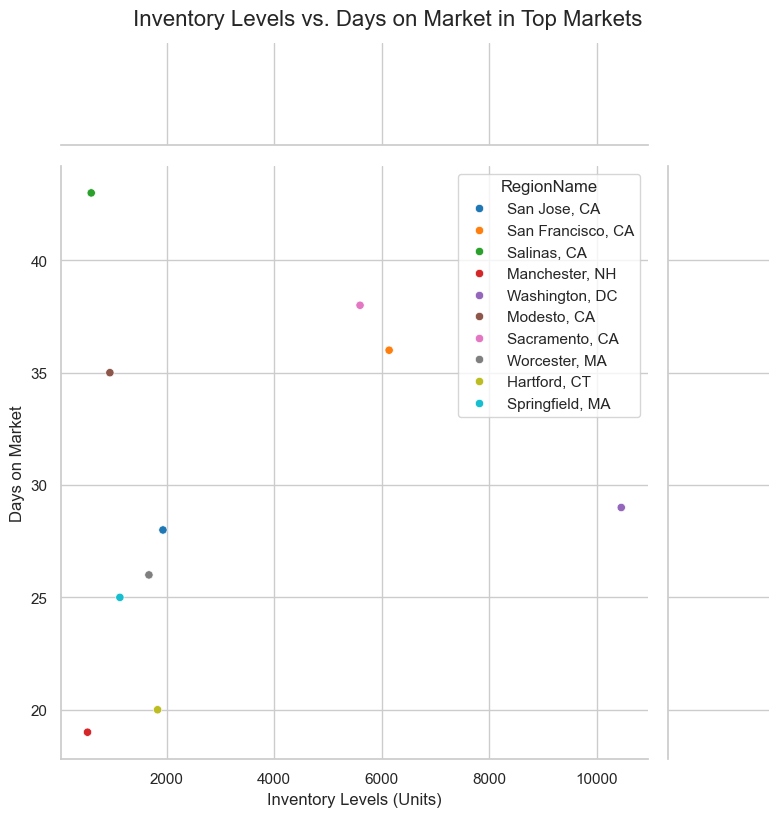

In [10]:
# joint plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.jointplot(
    data=investment_data,
    x="Inventory_Latest",
    y="DaysOnMarket_Latest",
    kind="scatter",
    hue="RegionName",
    palette="tab10",
    height=8,
    marginal_kws=dict(bins=20, fill=True),
)

plt.suptitle("Inventory Levels vs. Days on Market in Top Markets", y=1.02, fontsize=16)
plt.xlabel("Inventory Levels (Units)")
plt.ylabel("Days on Market")
plt.show()



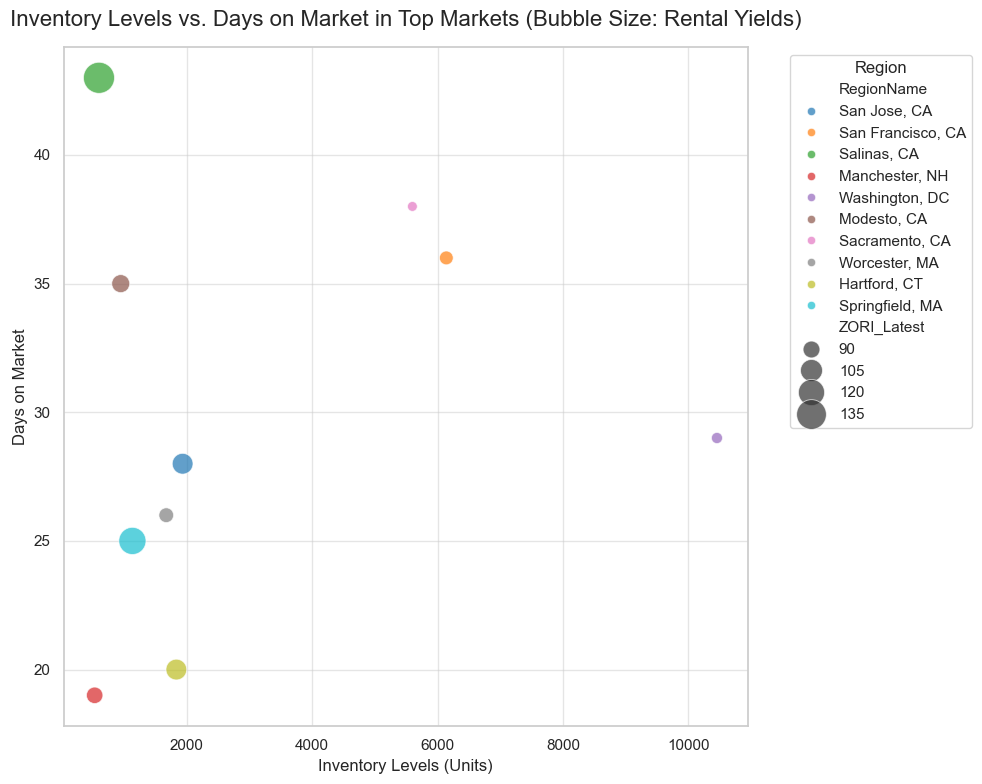

In [11]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Bubble graph
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a bubble graph
sns.scatterplot(
    data=investment_data,
    x="Inventory_Latest",
    y="DaysOnMarket_Latest",
    size="ZORI_Latest",  # Bubble size reflects rental yields (or choose another metric)
    hue="RegionName",  # Different colors for regions
    palette="tab10",  # Color palette for regions
    sizes=(50, 500),  # Adjust size range for bubbles
    alpha=0.7  # Transparency for better visibility
)

# Add titles and labels
plt.title("Inventory Levels vs. Days on Market in Top Markets (Bubble Size: Rental Yields)", fontsize=16, pad=15)
plt.xlabel("Inventory Levels (Units)", fontsize=12)
plt.ylabel("Days on Market", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Region")
plt.grid(alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()



### **Inventory Levels vs. Days on Market**

These visualizations explore the relationship between **Inventory Levels** and **Days on Market** in the top-performing real estate markets. 

  - **Scatter Plot**: Each point represents a market (region), showing how much inventory is available (x-axis) and how quickly homes are selling (y-axis).
  - **Hue for Region Names**: Each market is color-coded to help differentiate between the top-performing locations.
  - **Marginal Distributions**: Histograms along the axes show the distribution of inventory levels and days on market, revealing overall trends.
  -  **Bubble Chart**: This bubble chart explores the relationship between **Inventory Levels** (x-axis) and **Days on Market** (y-axis) in the top-performing real estate markets. It also incorporates:
- **Bubble Size**: Reflects rental yields (ZORI_Latest), with larger bubbles representing higher rental profitability.
- **Hue for Region Names**: Each region is color-coded, allowing easy differentiation between markets.


- **Key Insights**:
  1. **Low Inventory, Low Days on Market**:  
     Markets with low inventory and quick sales (e.g., low days on market) are highly competitive, making them ideal for flipping or quick resale. These markets indicate high buyer demand and fast-moving properties.
  2. **High Inventory, High Days on Market**:  
     Markets with higher inventory and longer days on market may offer opportunities for investors to negotiate better deals. These areas are more suited for rental investments, where securing a property at a lower cost may yield higher returns over time.
  3. **Balanced Markets**:  
     Some markets show moderate inventory levels and days on market, striking a balance between availability and demand. These markets can be a good choice for both flipping and long-term investments.

- **Why I care**:  
  This visualization helps you identify markets that align with your goals:
  - For **quick resale**: Look for markets with low inventory and days on market.  
  - For **long-term rental investments**: Focus on markets with higher inventory, as they may provide more favorable purchase conditions.

Th scatter plot and bubble chart show how competitive a market is.


In [12]:
print(investment_data.columns)


Index(['RegionName', 'StateName', 'ZHVI_Latest', 'ZORI_Latest',
       'MarketTemp_Latest', 'ZHVI_Rank', 'ZORI_Rank', 'MarketTemp_Rank',
       'Overall_Rank', 'Inventory_Latest', 'DaysOnMarket_Latest'],
      dtype='object')


In [13]:
# Rename columns for heatmp
investment_data = investment_data.rename(columns={
    "inventory_latest": "Inventory",
    "days_on_market_latest": "DaysOnMarket"
})

In [14]:
# Merge inventory and days on market data with top markets
investment_data = pd.merge(
    top_markets,
    inventory_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'Inventory'}),
    on=['RegionName', 'StateName'],
    how='inner'
)
investment_data = pd.merge(
    investment_data,
    dttp_data[['RegionName', 'StateName', '2024-10-31']].rename(columns={'2024-10-31': 'DaysOnMarket'}),
    on=['RegionName', 'StateName'],
    how='inner'
)

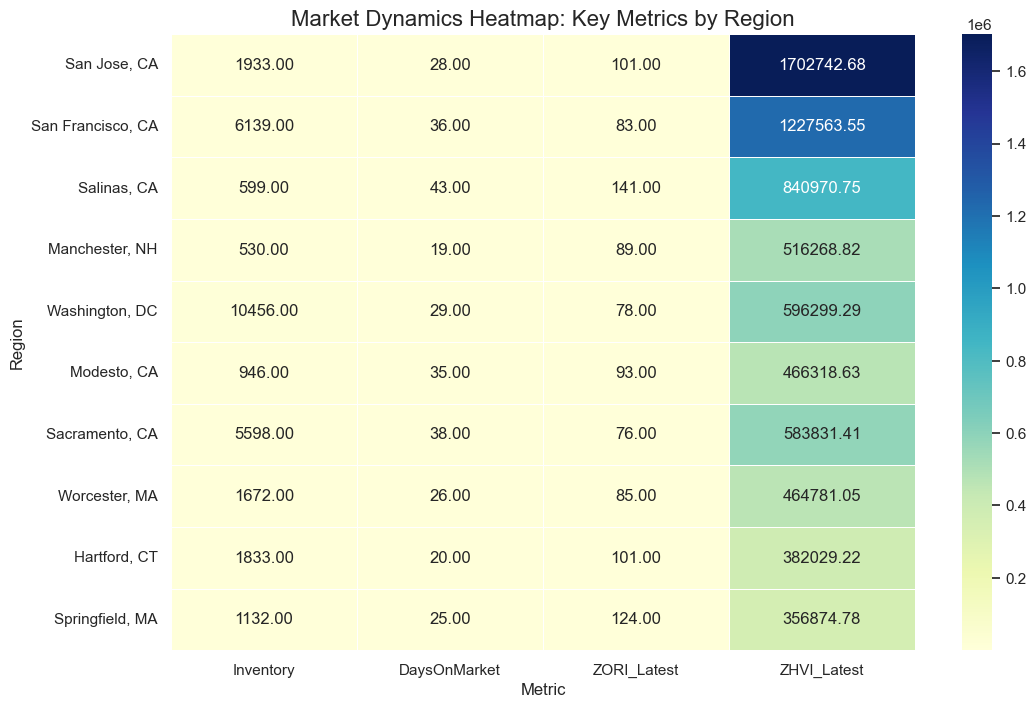

In [15]:
# Prepare data for the heatmap
heatmap_data = investment_data.set_index("RegionName")[["Inventory", "DaysOnMarket", "ZORI_Latest", "ZHVI_Latest"]]


# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Market Dynamics Heatmap: Key Metrics by Region", fontsize=16)
plt.ylabel("Region", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.show()



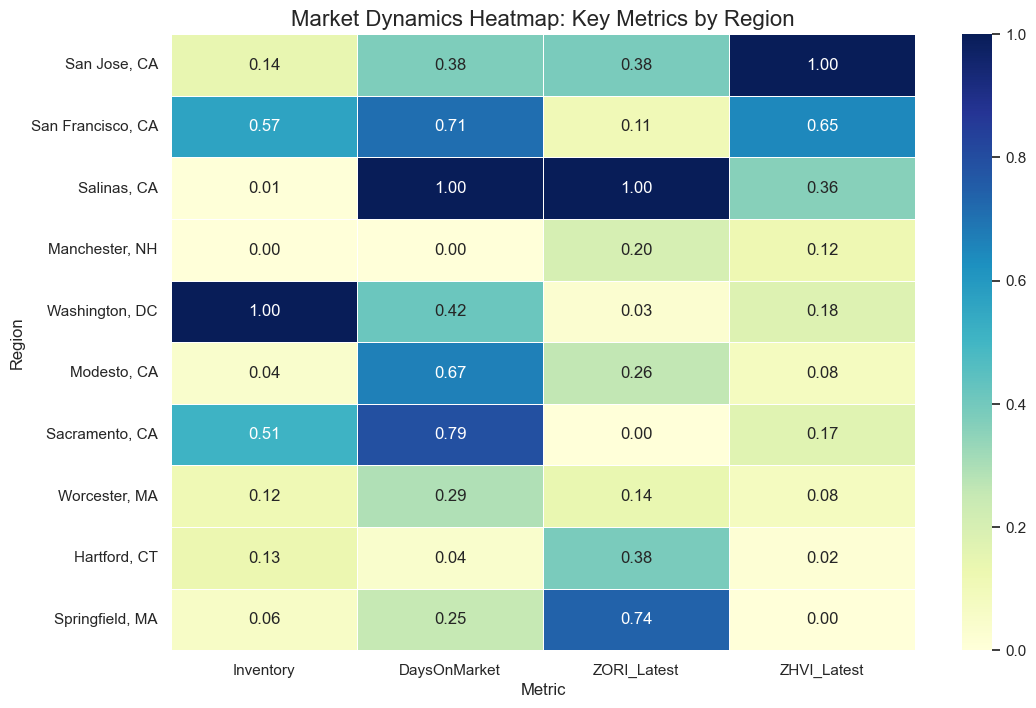

In [16]:
# exact same as before but with each metric normalized, easier on the eyes
heatmap_data = investment_data.set_index("RegionName")[["Inventory", "DaysOnMarket", "ZORI_Latest", "ZHVI_Latest"]]
#added after too much trial and error to "normalize the data"
heatmap_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Market Dynamics Heatmap: Key Metrics by Region", fontsize=16)
plt.ylabel("Region", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.show()



## **Market Dynamics Heatmap: Key Metrics by Region**

This heatmap provides a side-by-side comparison of the four metrics provided by Zillow metrics across several regions. Each metric is normalized (scaled between 0 and 1) to make comparisons across different scales possible. Darker shades indicate higher values, while lighter shades indicate lower values.

---

### **Zillow Metrics Explained**
1. **Inventory**:
   - Measures the number of homes available for sale in the region.
   - **Darker cells** (higher values): Indicate regions with more inventory, suggesting a buyer's market with less competition.
   - **Lighter cells** (lower values): Indicate tighter inventory, signaling a seller's market.

2. **Days on Market (DOM)**:
   - Tracks how quickly properties are selling in the region.
   - **Darker cells** (higher values): Indicate properties take longer to sell, possibly due to lower demand or higher pricing.
   - **Lighter cells** (lower values): Indicate "hot" markets with high buyer demand and quick sales.

3. **ZORI_Latest**:
   - Reflects the rental yields (Zillow Observed Rent Index) in the region.
   - **Darker cells** (higher values): Indicate stronger rental demand and higher profitability for landlords.
   - **Lighter cells** (lower values): Suggest lower rental profitability.

4. **ZHVI_Latest**:
   - Represents home value appreciation (Zillow Home Value Index).
   - **Darker cells** (higher values): Indicate regions with strong price growth and high property values.
   - **Lighter cells** (lower values): Suggest lower appreciation potential.

---

### **Key Insights**
1. **San Jose, CA**:
   - **Low Inventory** (0.14) but **High ZHVI_Latest** (1.00): Indicates a highly competitive market with strong home value growth, ideal for *immediate* appreciation-focused investments.

2. **Salinas, CA**:
   - **Extremely Low Inventory** (0.01) and **High ZORI_Latest** (1.00): Suggests a tight rental market with high profitability for landlords.

3. **Manchester, NH**:
   - **Very Low Inventory** (0.00) and **Moderate Rental Yields** (0.20): Indicates strong demand but lower rental profitability compared to other markets.

4. **Washington, DC**:
   - **High Inventory** (1.00) but **Low Rental Yields** (0.03): Suggests a cooling market with opportunities for negotiation but less attractive for rental income.

5. **Springfield, MA**:
   - **Moderate Inventory** (0.06) and **High ZORI_Latest** (0.74): A balanced market offering strong rental yields and moderate competition.

---

### **How to Use This Heatmap**
- **For Flipping**:
  - Focus on regions with **low inventory** and **high ZHVI_Latest**, such as *San Jose, CA* and *Salinas, CA*.
- **For Rental Income**:
  - Target regions with **high ZORI_Latest**, like *Salinas, CA* or *Springfield, MA*, for strong rental profitability.
- **Bonus Opportunities**:
  - Check out regions with **high inventory** and **long days on market**, like *Washington, DC*, where buyers have leverage.



### **Conclusion on Q3 -- Should You Invest Now or Wait? Where Should You Invest?**

Given the current market trends, **now is a favorable time to invest** in real estate. Many markets demonstrate strong price growth and competitive activity, suggesting demand remains high. 

- **Invest Now If**: You aim to capitalize on current market dynamics, particularly in competitive regions with strong price appreciation like **San Jose, CA**. Quick resale opportunities are better in these high-demand markets.
- **Recommended Markets**:
  - For rental income: *Salinas, CA* and *Springfield, MA*, with strong rental yields and moderate competition.
  - For flipping: *San Francisco, CA* and *San Jose, CA*, where price appreciation remains robust, and demand is strong.

Investing now in the above chosen markets to yield significant returns.